## manipulation SQL Querys with SQLGlot

SQLGlot is a powerful and versatile SQL parser, transpiler, and optimizer library for Python.

SQLGlot allows you to parse SQL queries into abstract syntax trees (ASTs), manipulate those trees, and then generate SQL again. This capability enables several key features:

1. SQL dialect translation: Convert queries between different SQL dialects like PostgreSQL, MySQL, Snowflake, and many others.

2. Query analysis and optimization: Examine and modify query structure programmatically.

3. SQL generation: Build complex SQL queries programmatically using Python.

4. Syntax checking and formatting: Validate and prettify SQL queries.

Some notable aspects of SQLGlot include:

- Support for a wide range of SQL dialects
- No dependencies, making it lightweight and easy to integrate
- Extensibility to add custom functions or dialects
- Preservation of comments and formatting during parsing and generation

SQLGlot is particularly useful for data engineers, database administrators, and developers working with multiple database systems or needing to programmatically manipulate SQL.

SQLGlot, like many SQL parsing and manipulation libraries, works extensively with Abstract Syntax Trees (ASTs). Here how this works in the context of SQLGlot:

- Parsing:
When you input a SQL query into SQLGlot, it parses the SQL text and constructs an AST representing the structure of that query.

- Representation:
The AST in SQLGlot represents SQL-specific constructs. For example, SELECT statements, WHERE clauses, JOIN operations, and individual expressions are all represented as nodes in the tree.
- Manipulation:
Once the SQL is parsed into an AST, SQLGlot allows you to traverse and modify this tree structure. This is where much of the library's power comes from.
- Generation:
After any manipulations, SQLGlot can then convert the AST back into SQL text, potentially in a different dialect.

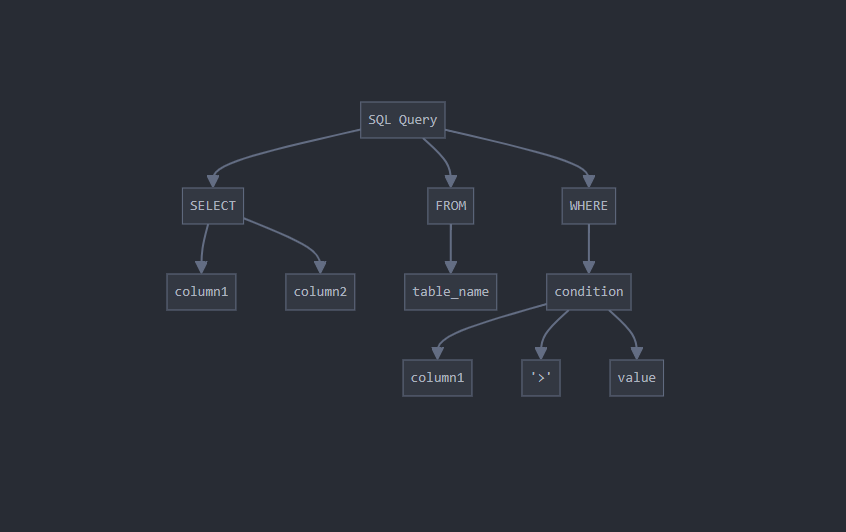

#### python version

In [35]:
!python -V

Python 3.8.10


#### libraries

In [38]:
from sqlglot import select, condition, parse_one, exp

#### version library

In [119]:
print(sqlglot.__version__)

25.21.2


## Simple example

In [10]:
where = condition("city=cali").and_("y=1")
select("*").from_("y").where(where).sql()

'SELECT * FROM y WHERE city = cali AND y = 1'

#### Adding element to a where clause 

In [26]:

# Original SQL query
query = "SELECT * FROM sales WHERE region = 'North'"

# Parse the query into an Expression object
parsed = parse_one(query)

# Extract the existing WHERE clause
existing_where = parsed.args.get('where')

# Create a new condition to add, e.g., "AND amount > 1000"
new_condition = exp.GT(
    this=exp.column("amount"),
    expression=exp.Literal.number(2000)
)

# Combine the existing WHERE clause with the new condition using AND
combined_where = exp.and_(existing_where, new_condition)

# Set the new WHERE clause back into the parsed query
parsed.set("where", combined_where)

# Reconstruct the SQL query
modified_query = parsed.sql()
print("Modified SQL Query:")
print(modified_query)


Modified SQL Query:
SELECT * FROM sales WHERE region = 'North' AND amount > 2000


In [28]:

# Original SQL query
query = "SELECT * FROM sales WHERE region = 'North'"

# Parse the query into an Expression object
parsed = parse_one(query)

# Extract the existing WHERE clause
existing_where = parsed.args.get('where')

# Create a new condition to add, e.g., "AND amount > 1000"
new_condition = exp.LT(
    this=exp.column("amount"),
    expression=exp.Literal.number(2000)
)

# Combine the existing WHERE clause with the new condition using AND
combined_where = exp.and_(existing_where, new_condition)

# Set the new WHERE clause back into the parsed query
parsed.set("where", combined_where)

# Reconstruct the SQL query
modified_query = parsed.sql()
print("Modified SQL Query:")
print(modified_query)

Modified SQL Query:
SELECT * FROM sales WHERE region = 'North' AND amount < 2000


In [27]:

# Original SQL query
query = "SELECT * FROM sales WHERE region = 'North'"

# Parse the query
parsed = parse_one(query)

# Create a new condition, e.g., "OR region = 'South'"
new_condition = exp.EQ(
    this=exp.column("region"),
    expression=exp.Literal.string("South")
)

# Combine with existing WHERE clause using OR
combined_where = exp.or_(parsed.args.get('where'), new_condition)

# Set the new WHERE clause
parsed.set("where", combined_where)

# Reconstruct the SQL query
modified_query = parsed.sql()
print("Modified SQL Query:")
print(modified_query)


Modified SQL Query:
SELECT * FROM sales WHERE region = 'North' OR region = 'South'


#### identify parts of a query

In [29]:

# Parse the original query

sql_query="""
SELECT department, AVG(salary) as avg_salary, COUNT(*) as employee_count
FROM employees
WHERE hire_date >= '2020-01-01'
GROUP BY department
HAVING COUNT(*) > 5
ORDER BY avg_salary DESC
"""
query = parse_one(sql_query)

# Find the WHERE clause
where_exp = query.find(exp.Group)

print(where_exp)



GROUP BY department


#### Change the name of a table in a simple query

In [50]:
import sqlglot
from sqlglot import exp

def replace_table_names(sql, new_table_name):
    """
    Replaces all table names in a SQL statement with a new table name.

    Args:
        sql (str): The original SQL statement.
        new_table_name (str): The new table name to use.

    Returns:
        str: The SQL statement with all table names replaced.
    """
    # Parse the SQL statement into an AST
    expression = sqlglot.parse_one(sql)

    # Define a function to replace all table names
    def replace_tables(node):
        if isinstance(node, exp.Table):
            return exp.Table(this=new_table_name, alias=node.alias)
        return node

    # Apply the transformation
    new_expression = expression.transform(replace_tables)

    # Generate the new SQL statement
    return new_expression.sql()


# Original SQL statement
sql = "SELECT * FROM my_table WHERE id = 1;"
sql = """
    SELECT department, AVG(salary) AS average_salary
    FROM employees
    GROUP BY department
    HAVING AVG(salary) > 50000
    ORDER BY average_salary DESC;
"""


# Replace all table names with 'new_table'
new_sql = replace_table_names(sql, 'my_table_edu')

print(new_sql)


SELECT department, AVG(salary) AS average_salary FROM my_table_edu GROUP BY department HAVING AVG(salary) > 50000 ORDER BY average_salary DESC


#### identify a subquery in a  query

In [2]:
import sqlglot

def has_subquery(sql):
    try:
        parsed = sqlglot.parse_one(sql)
        return any(isinstance(node, sqlglot.exp.Subquery) for node in parsed.walk())
    except Exception:
        return False

# Example usage
sql_with_subquery = "SELECT * FROM (SELECT id FROM users) AS subquery"
sql_without_subquery = "SELECT * FROM users"
sql3="""
SELECT name, age 
FROM employees 
WHERE department = 'Sales';
"""

sql4="""
SELECT product_name, unit_price
FROM products
WHERE category_id = 1
ORDER BY unit_price DESC
LIMIT 5;
"""
sql5="""
SELECT department, AVG(salary) as avg_salary
FROM employees
GROUP BY department
HAVING AVG(salary) > 50000
ORDER BY avg_salary DESC;
"""
sql6="""
SELECT employee_name, salary
FROM employees
WHERE salary > (
    SELECT AVG(salary)
    FROM employees
    WHERE department = 'Sales'
)
ORDER BY salary DESC;
"""
sql7="""
SELECT p.product_name, p.unit_price
FROM products p
WHERE p.unit_price > (
    SELECT AVG(unit_price)
    FROM products
    WHERE category_id = p.category_id
)
ORDER BY p.category_id, p.unit_price DESC;
"""
sql8="""
SELECT o.order_id, c.customer_name, p.product_name, od.quantity, p.unit_price
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_details od ON o.order_id = od.order_id
JOIN products p ON od.product_id = p.product_id
WHERE o.order_date >= '2023-01-01'
  AND o.order_date < '2024-01-01'
ORDER BY o.order_id, p.product_name;

"""
sql="""
"""

print(has_subquery(sql_with_subquery))    # True
print(has_subquery(sql_without_subquery)) # False
print(has_subquery(sql3)) 
print(has_subquery(sql4)) 
print(has_subquery(sql5)) 
print(has_subquery(sql6)) 
print(has_subquery(sql7)) 
print(has_subquery(sql8)) 

True
False
False
False
False
True
True
False


#### identify a GROUP BY in a query in general

In [3]:
import sqlglot

def has_group_by(sql):
    try:
        parsed = sqlglot.parse_one(sql)
        return any(isinstance(node, sqlglot.exp.Group) for node in parsed.walk())
    except Exception:
        return False


In [4]:
# SQL queries to test has_group_by function
sql_queries = [
    # Queries with GROUP BY
    "SELECT department, AVG(salary) FROM employees GROUP BY department",
    "SELECT country, COUNT(*) FROM customers GROUP BY country",
    "SELECT product_category, SUM(sales) FROM orders GROUP BY product_category",
    "SELECT YEAR(order_date), COUNT(*) FROM orders GROUP BY YEAR(order_date)",
    "SELECT department, job_title, AVG(salary) FROM employees GROUP BY department, job_title",
    "SELECT customer_id, SUM(total) AS total_spent FROM orders GROUP BY customer_id HAVING total_spent > 1000",
    "SELECT product_id, AVG(rating) FROM reviews GROUP BY product_id ORDER BY AVG(rating) DESC",
    "SELECT DATE(timestamp), COUNT(*) FROM logs GROUP BY DATE(timestamp)",
    "SELECT category, subcategory, COUNT(*) FROM products GROUP BY GROUPING SETS ((category), (category, subcategory))",
    "SELECT EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date), SUM(amount) FROM transactions GROUP BY EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)",

    # Queries without GROUP BY
    "SELECT * FROM employees",
    "SELECT name, salary FROM employees WHERE department = 'Sales'",
    "SELECT product_name, price FROM products ORDER BY price DESC",
    "SELECT DISTINCT category FROM products",
    "SELECT customer_name FROM customers WHERE country IN ('USA', 'Canada')",
    "SELECT order_id, customer_id, order_date FROM orders WHERE order_date BETWEEN '2023-01-01' AND '2023-12-31'",
    "SELECT e.name, d.department_name FROM employees e JOIN departments d ON e.department_id = d.id",
    "SELECT product_name, (SELECT AVG(price) FROM products) AS avg_price FROM products",
    "SELECT customer_name, (SELECT COUNT(*) FROM orders WHERE orders.customer_id = customers.id) AS order_count FROM customers",
    "WITH ranked_products AS (SELECT *, RANK() OVER (PARTITION BY category ORDER BY price DESC) AS price_rank FROM products) SELECT * FROM ranked_products WHERE price_rank <= 3"
]

# Test the has_group_by function
for i, query in enumerate(sql_queries, 1):
    print(f"Query {i}: {'Has GROUP BY' if has_group_by(query) else 'No GROUP BY'}")
    print(f"SQL: {query}\n")

Query 1: Has GROUP BY
SQL: SELECT department, AVG(salary) FROM employees GROUP BY department

Query 2: Has GROUP BY
SQL: SELECT country, COUNT(*) FROM customers GROUP BY country

Query 3: Has GROUP BY
SQL: SELECT product_category, SUM(sales) FROM orders GROUP BY product_category

Query 4: Has GROUP BY
SQL: SELECT YEAR(order_date), COUNT(*) FROM orders GROUP BY YEAR(order_date)

Query 5: Has GROUP BY
SQL: SELECT department, job_title, AVG(salary) FROM employees GROUP BY department, job_title

Query 6: Has GROUP BY
SQL: SELECT customer_id, SUM(total) AS total_spent FROM orders GROUP BY customer_id HAVING total_spent > 1000

Query 7: Has GROUP BY
SQL: SELECT product_id, AVG(rating) FROM reviews GROUP BY product_id ORDER BY AVG(rating) DESC

Query 8: Has GROUP BY
SQL: SELECT DATE(timestamp), COUNT(*) FROM logs GROUP BY DATE(timestamp)

Query 9: Has GROUP BY
SQL: SELECT category, subcategory, COUNT(*) FROM products GROUP BY GROUPING SETS ((category), (category, subcategory))

Query 10: Has 

In [5]:
import sqlglot

def has_group_by_in_subquery(sql):
    try:
        parsed = sqlglot.parse_one(sql)
        return _has_group_by_in_subquery(parsed)
    except Exception:
        return False

def _has_group_by_in_subquery(node):
    if isinstance(node, sqlglot.exp.Select):
        if any(isinstance(child, sqlglot.exp.Group) for child in node.walk()):
            return True
        for child in node.walk():
            if _has_group_by_in_subquery(child):
                return True
    return False

#### remove a colum from select statement 1 at tieme

In [81]:
import sqlglot
from sqlglot import exp, parse_one

def remove_column_from_select(sql, column_to_remove):
    def transform(node):
        if isinstance(node, exp.Select):
            new_expressions = [
                expr for expr in node.args['expressions']
                if not (isinstance(expr, exp.Column) and expr.name == column_to_remove)
            ]
            return exp.Select(**{**node.args, 'expressions': new_expressions})
        return node

    parsed = parse_one(sql)
    modified = parsed.transform(transform)
    return modified.sql()

# Example usage
original_sql = "SELECT id, name, age, email FROM users WHERE age > 18"
modified_sql = remove_column_from_select(original_sql, "email")

print("Original SQL:", original_sql)
print("Modified SQL:", modified_sql)

Original SQL: SELECT id, name, age, email FROM users WHERE age > 18
Modified SQL: SELECT id, name, age FROM users WHERE age > 18


#### remove more than 1 column at a time in SELECT statement , the parameter must be a list

In [82]:
import sqlglot
from sqlglot import exp, parse_one

def remove_columns_from_select(sql, columns_to_remove):
    def transform(node):
        if isinstance(node, exp.Select):
            new_expressions = [
                expr for expr in node.args['expressions']
                if not (isinstance(expr, exp.Column) and expr.name in columns_to_remove)
            ]
            return exp.Select(**{**node.args, 'expressions': new_expressions})
        return node

    parsed = parse_one(sql)
    modified = parsed.transform(transform)
    return modified.sql()

# Example usage
original_sql = "SELECT id, name, age, email, phone, address FROM users WHERE age > 18"
columns_to_remove = ["age", "phone", "address"]
modified_sql = remove_columns_from_select(original_sql, columns_to_remove)

print("Original SQL:", original_sql)
print("Modified SQL:", modified_sql)
print("Columns removed:", columns_to_remove)

# Additional example with different columns
another_sql = "SELECT product_id, name, price, stock, category, supplier FROM products"
another_columns_to_remove = ["stock", "supplier"]
another_modified_sql = remove_columns_from_select(another_sql, another_columns_to_remove)

print("\nAnother Original SQL:", another_sql)
print("Another Modified SQL:", another_modified_sql)
print("Columns removed:", another_columns_to_remove)

Original SQL: SELECT id, name, age, email, phone, address FROM users WHERE age > 18
Modified SQL: SELECT id, name, email FROM users WHERE age > 18
Columns removed: ['age', 'phone', 'address']

Another Original SQL: SELECT product_id, name, price, stock, category, supplier FROM products
Another Modified SQL: SELECT product_id, name, price, category FROM products
Columns removed: ['stock', 'supplier']


#### exellent code to remove categories in a group by statement

In [83]:
import sqlglot
from sqlglot import exp, parse_one

def remove_fields_from_group_by(sql, fields_to_remove):
    def transform(node):
        if isinstance(node, exp.Group):
            new_expressions = [
                expr for expr in node.args['expressions']
                if not (isinstance(expr, exp.Column) and expr.name in fields_to_remove)
            ]
            # If all fields are removed, return None to remove the entire GROUP BY
            if not new_expressions:
                return None
            return exp.Group(**{**node.args, 'expressions': new_expressions})
        return node

    parsed = parse_one(sql)
    modified = parsed.transform(transform)
    return modified.sql()

# Example usage
original_sql = "SELECT department, job_title, AVG(salary) FROM employees GROUP BY department, job_title, hire_year"
fields_to_remove = ["job_title", "hire_year"]
modified_sql = remove_fields_from_group_by(original_sql, fields_to_remove)

print("Original SQL:", original_sql)
print("Modified SQL:", modified_sql)
print("Fields removed from GROUP BY:", fields_to_remove)

# Additional example
another_sql = "SELECT category, subcategory, YEAR(order_date), SUM(sales) FROM orders GROUP BY category, subcategory, YEAR(order_date)"
another_fields_to_remove = ["subcategory"]
another_modified_sql = remove_fields_from_group_by(another_sql, another_fields_to_remove)

print("\nAnother Original SQL:", another_sql)
print("Another Modified SQL:", another_modified_sql)
print("Fields removed from GROUP BY:", another_fields_to_remove)

# Example where all GROUP BY fields are removed
all_fields_sql = "SELECT department, AVG(salary) FROM employees GROUP BY department"
all_fields_to_remove = ["department"]
all_fields_modified_sql = remove_fields_from_group_by(all_fields_sql, all_fields_to_remove)

print("\nAll Fields Original SQL:", all_fields_sql)
print("All Fields Modified SQL:", all_fields_modified_sql)
print("Fields removed from GROUP BY:", all_fields_to_remove)

Original SQL: SELECT department, job_title, AVG(salary) FROM employees GROUP BY department, job_title, hire_year
Modified SQL: SELECT department, job_title, AVG(salary) FROM employees GROUP BY department
Fields removed from GROUP BY: ['job_title', 'hire_year']

Another Original SQL: SELECT category, subcategory, YEAR(order_date), SUM(sales) FROM orders GROUP BY category, subcategory, YEAR(order_date)
Another Modified SQL: SELECT category, subcategory, YEAR(order_date), SUM(sales) FROM orders GROUP BY category, YEAR(order_date)
Fields removed from GROUP BY: ['subcategory']

All Fields Original SQL: SELECT department, AVG(salary) FROM employees GROUP BY department
All Fields Modified SQL: SELECT department, AVG(salary) FROM employees
Fields removed from GROUP BY: ['department']


#### trying to remove condition in WHERE clause

work perfect ones a time, pass unit test

In [5]:
import sqlglot

def modify_sql_query(sql_query, condition_to_remove):
    expression = sqlglot.parse_one(sql_query)
    def remove_condition(exp):
        if isinstance(exp, sqlglot.expressions.And):
            left_matches = exp.left.sql().strip().lower() == condition_to_remove.lower()
            right_matches = exp.right.sql().strip().lower() == condition_to_remove.lower()
            if left_matches and right_matches:
                return None
            elif left_matches:
                return exp.right
            elif right_matches:
                return exp.left
        elif isinstance(exp, sqlglot.expressions.Where):
            # If the condition matches exactly and there are no other conditions, remove the WHERE clause
            if exp.this.sql().strip().lower() == condition_to_remove.lower():
                return None
        return exp

    # Modify the AST by removing the specified condition
    modified_expression = expression.transform(remove_condition)

    # If the entire WHERE clause was removed, remove the WHERE keyword from the final SQL
    result_sql = modified_expression.sql()
    if "WHERE" in result_sql.upper() and "WHERE" == result_sql.strip()[-5:].upper():
        result_sql = result_sql.replace(" WHERE", "")  # Remove dangling WHERE

    return result_sql


#### Find a subquery inside of a query to work with

In [16]:
import sqlglot

# Example SQL query with subqueries
sql_query = """
SELECT * FROM (
    SELECT id, name FROM users WHERE age > 20
) AS subquery
WHERE name LIKE 'A%'
"""

# Parse the SQL query
expression = sqlglot.parse_one(sql_query)

# Function to recursively find all subqueries
def find_subqueries(exp, subqueries=[]):
    # Check if the expression is a subquery: a SELECT nested in another expression
    if isinstance(exp, sqlglot.expressions.Select) and exp.parent and not exp.parent.is_type('QUERY'):
        subqueries.append(exp)
    for arg in exp.args.values():
        if isinstance(arg, sqlglot.expressions.Expression):
            find_subqueries(arg, subqueries)
    return subqueries

# Extract subqueries
subqueries = find_subqueries(expression)

# Print extracted subqueries
for subquery in subqueries:
    # Ensure the subquery is directly transpiled without additional string processing
    subquery_sql = sqlglot.transpile(subquery.sql(), pretty=True)
    print("Subquery SQL:", subquery_sql)
    print(type(subquery_sql))





Subquery SQL: ['SELECT\n  id,\n  name\nFROM users\nWHERE\n  age > 20']
<class 'list'>


In [22]:
import sqlglot

# Example SQL query with a subquery
sql_query = """
SELECT * FROM (
    SELECT id, name FROM users WHERE age > 20
) AS subquery
WHERE name LIKE 'A%'
"""

# Parse the SQL query
expression = sqlglot.parse_one(sql_query)

def modify_subqueries(exp):
    if isinstance(exp, sqlglot.expressions.Select):
        # Check if this is a subquery
        if exp.parent and not exp.parent.is_type('QUERY'):
            # Look for the WHERE clause to modify it
            where_clause = exp.find(sqlglot.expressions.Where)
            if where_clause:
                # Modify the condition within the WHERE clause
                # Create a new condition expression directly
                new_condition = sqlglot.parse_one("age > 25").expressions[0].args['this']
                where_clause.this = new_condition

    # Recursively apply to all subexpressions
    for arg in exp.args.values():
        if isinstance(arg, list):
            for sub_arg in arg:
                if isinstance(sub_arg, sqlglot.expressions.Expression):
                    modify_subqueries(sub_arg)
        elif isinstance(arg, sqlglot.expressions.Expression):
            modify_subqueries(arg)

# Modify the subqueries
modify_subqueries(expression)

# Generate the full modified SQL query
modified_sql = expression.sql(pretty=True)
print("Modified SQL Query:", modified_sql)





IndexError: list index out of range

## add fields to select and group by

given a simple query and a list the new query add element in the SELECT and GROUP BY at the same time

In [120]:
import sqlglot
from sqlglot.expressions import Identifier

def add_fields_to_select_and_group_by(sql_query, fields_to_add):

    # Parse the SQL query
    parsed = sqlglot.parse_one(sql_query)
    
    # Ensure fields_to_add is a list
    if not isinstance(fields_to_add, list):
        fields_to_add = [fields_to_add]
    
    # Get existing SELECT field names
    existing_select_fields = [select.alias_or_name for select in parsed.selects]
    
    # Add fields to SELECT clause
    for field in fields_to_add:
        if field not in existing_select_fields:
            parsed.selects.append(Identifier(this=field))
    
    # Add fields to GROUP BY clause
    group_by = parsed.args.get('group')
    
    if group_by:
        # Get existing GROUP BY field names
        existing_group_by_fields = [expr.sql() for expr in group_by.expressions]
        for field in fields_to_add:
            if field not in existing_group_by_fields:
                group_by.expressions.append(Identifier(this=field))
    else:
        # If GROUP BY does not exist, create it
        from sqlglot.expressions import Group
        group_expressions = [Identifier(this=field) for field in fields_to_add]
        parsed.set('group', Group(expressions=group_expressions))
    
    # Return the modified SQL query
    return parsed.sql()


In [122]:
# Original SQL query
sql_query1 = """
SELECT customer_id, city, SUM(amount) AS total_amount
FROM orders
GROUP BY customer_id
"""

# Only works well wihout subquery
sql_query2 = """
SELECT sub.customer_id, sub.city, SUM(sub.total_amount)
FROM (
    SELECT customer_id, city, SUM(amount) AS total_amount
    FROM orders
    GROUP BY customer_id, city
) AS sub
GROUP BY sub.customer_id, sub.city
"""
# Fields you want to add
fields_to_add = ['other', 'other1']

# Call the function
modified_sql = add_fields_to_select_and_group_by(sql_query2, fields_to_add)

# Print the modified SQL query
print(modified_sql)

SELECT sub.customer_id, sub.city, SUM(sub.total_amount), other, other1 FROM (SELECT customer_id, city, SUM(amount) AS total_amount FROM orders GROUP BY customer_id, city) AS sub GROUP BY sub.customer_id, sub.city, other, other1


# extract some fields in select and in group by

this can be useful because I already have a function that add from a list element to select and group by

In [15]:
def extract_fields(sql_query):
    """
    Extracts field names from the SELECT and GROUP BY clauses, excluding functions/operators in SELECT.

    Parameters:
    - sql_query (str): The SQL query string.

    Returns:
    - dict: A dictionary with keys 'select_fields' and 'group_by_fields', each containing a list of field names.
    """
    import sqlglot
    from sqlglot.expressions import Column, Identifier

    # Parse the SQL query
    parsed = sqlglot.parse_one(sql_query)

    # Extract fields from SELECT clause
    select_fields = []
    for select_expr in parsed.selects:
        # If the expression is a simple column or identifier, add it
        if isinstance(select_expr, (Column, Identifier)):
            select_fields.append(select_expr.sql())
        else:
            # Skip functions and expressions
            continue

    # Extract fields from GROUP BY clause
    group_by_fields = []
    group_by = parsed.args.get('group')
    if group_by:
        for group_expr in group_by.expressions:
            # Get the SQL representation of the group by expressions
            group_by_fields.append(group_expr.sql())

    # Return the extracted fields
    return {
        'select_fields': select_fields,
        'group_by_fields': group_by_fields
    }


In [16]:
# Your SQL query as a string
sql_query = """
SELECT customer_id, city, SUM(amount) AS total_amount
FROM orders
GROUP BY customer_id
"""

# Call the function
fields = extract_fields(sql_query)

# Access the extracted fields
select_fields = fields['select_fields']
group_by_fields = fields['group_by_fields']

# Print the results
print("Fields in SELECT clause", select_fields)
print("Fields in GROUP BY clause:", group_by_fields)


Fields in SELECT clause ['customer_id', 'city']
Fields in GROUP BY clause: ['customer_id']


# extract some fields in select and in group by recursively

This is very useful to have a list of values in select and group by. the this categories are passed to the function to add

In [6]:
def extract_fields_recursive(sql_query):
    """
    Recursively extracts field names from all SELECT and GROUP BY clauses in the SQL query,
    including those within subqueries, excluding functions/operators in SELECT clauses.

    Parameters:
    - sql_query (str): The SQL query string.

    Returns:
    - list: A list of dictionaries, each containing 'select_fields' and 'group_by_fields' for each SELECT clause.
    """
    import sqlglot
    from sqlglot.expressions import Select, Column, Identifier

    # List to hold the results from all SELECT clauses
    results = []

    # Parse the SQL query
    parsed = sqlglot.parse_one(sql_query)

    # Define a recursive function to traverse the AST
    def traverse(node):
        if isinstance(node, Select):
            # Extract fields from the current SELECT and GROUP BY clauses
            select_fields = []
            for select_expr in node.selects:
                if isinstance(select_expr, (Column, Identifier)):
                    select_fields.append(select_expr.sql())
            group_by_fields = []
            group_by = node.args.get('group')
            if group_by:
                for group_expr in group_by.expressions:
                    group_by_fields.append(group_expr.sql())

            # Add the extracted fields to the results list
            results.append({
                'select_fields': select_fields,
                'group_by_fields': group_by_fields
            })

        # Recursively traverse child nodes
        for child in node.args.values():
            if isinstance(child, list):
                for item in child:
                    if isinstance(item, sqlglot.Expression):
                        traverse(item)
            elif isinstance(child, sqlglot.Expression):
                traverse(child)

    # Start traversal from the root node
    traverse(parsed)

    return results


In [130]:
# Your SQL query as a string
sql_query1 = """
SELECT
  customer_id,
  city,
  (SELECT
     SUM(amount) AS total_amount,
     region
   FROM orders_sub
   WHERE orders_sub.customer_id = orders.customer_id
   GROUP BY region) AS sub_total
FROM orders
GROUP BY customer_id, city
"""

sql_query2 = """
SELECT
  customer_id,
  city,
  COUNT(other)
FROM orders
GROUP BY customer_id, city
"""


# Call the function
fields_list = extract_fields_recursive(sql_query2)

# Print the results
for idx, fields in enumerate(fields_list, start=1):
    print(f"SELECT clause {idx}:")
    print("  Fields in SELECT clause :", fields['select_fields'])
    print("  Fields in GROUP BY clause:", fields['group_by_fields'])
    print()


SELECT clause 1:
  Fields in SELECT clause : ['customer_id', 'city']
  Fields in GROUP BY clause: ['customer_id', 'city']



# add fields to select and group by in querys and subequerys

this code work well for select and subquerys

In [123]:
import sqlglot
from sqlglot.expressions import Select, Column, Identifier, Group

def add_fields_to_queries(sql_query, outer_fields_to_add, subquery_fields_to_add):
    """
    Adds fields to the SELECT and GROUP BY clauses of the outer query and subqueries.

    Parameters:
    - sql_query (str): The SQL query string.
    - outer_fields_to_add (list of str): Fields to add to the outer query.
    - subquery_fields_to_add (list of str): Fields to add to subqueries.

    Returns:
    - str: The modified SQL query.
    """
    # Parse the SQL query
    parsed = sqlglot.parse_one(sql_query)
    
    # Define a helper function to recursively traverse and modify the query
    def traverse_and_modify(node, is_subquery=False):
        # Determine which fields to add based on whether we're in a subquery
        fields_to_add = subquery_fields_to_add if is_subquery else outer_fields_to_add
        
        if isinstance(node, Select):
            # Get existing SELECT field names
            existing_select_fields = [select.alias_or_name for select in node.selects]
            # Add fields to SELECT clause
            for field in fields_to_add:
                if field not in existing_select_fields:
                    node.selects.append(Identifier(this=field))
            # Modify GROUP BY clause
            group_by = node.args.get('group')
            if group_by:
                existing_group_by_fields = [expr.sql() for expr in group_by.expressions]
                for field in fields_to_add:
                    if field not in existing_group_by_fields:
                        group_by.expressions.append(Identifier(this=field))
            else:
                # If GROUP BY does not exist, create it
                group_expressions = [Identifier(this=field) for field in fields_to_add]
                node.set('group', Group(expressions=group_expressions))
        
        # Recursively traverse child nodes
        for child in node.args.values():
            if isinstance(child, list):
                for item in child:
                    if isinstance(item, sqlglot.Expression):
                        # For subqueries, set is_subquery=True
                        traverse_and_modify(item, is_subquery=True)
            elif isinstance(child, sqlglot.Expression):
                traverse_and_modify(child, is_subquery=True)
    
    # Start traversal from the root node (outer query)
    traverse_and_modify(parsed, is_subquery=False)
    
    # Return the modified SQL query
    return parsed.sql()



In [126]:
sql_query1 = """
SELECT city, SUM(total_amount) AS city_total
FROM table1
WHERE total_amount > 1000
GROUP BY city
"""

sql_query2 = """
SELECT city, SUM(total_amount) AS city_total
FROM (
    SELECT customer_id, city, SUM(amount) AS total_amount
    FROM orders
    GROUP BY customer_id, city
) AS sub
WHERE total_amount > 1000
GROUP BY city
"""

# Define the fields to add
outer_fields_to_add = ['city1']
subquery_fields_to_add = ['city2']

# Call the function
modified_sql = add_fields_to_queries(sql_query2, outer_fields_to_add, subquery_fields_to_add)

# Print the modified SQL query
print(modified_sql)
print(sql_query2)



SELECT city, SUM(total_amount) AS city_total, city1 FROM (SELECT customer_id, city, SUM(amount) AS total_amount, city2 FROM orders GROUP BY customer_id, city, city2) AS sub WHERE total_amount > 1000 GROUP BY city, city1

SELECT city, SUM(total_amount) AS city_total
FROM (
    SELECT customer_id, city, SUM(amount) AS total_amount
    FROM orders
    GROUP BY customer_id, city
) AS sub
WHERE total_amount > 1000
GROUP BY city

